# Latent time predicted by scLTNN (Panceras)

Here, you will be briefly guided through the basics of how to use scLTNN. Once you are set, the following tutorials go straight into analysis of latent time by raw count of scRNA-seq.

In this tutorial, this started out as a demonstration that scLTNN would allow to reproduce most of latent time of scVelo. Compare with scVelo, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. See here for more details. It can be applied to your own data along the same lines.

In [ ]:
# update to the latest version, if not done yet.
!pip install scltnn --upgrade --quiet

In [1]:
import scltnn
import scanpy as sc
import scvelo as scv
import anndata

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


## Load the data
The analysis is based on the in-built pancreas data.

In [5]:
adata=scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 1945
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'spearmans_score', 'velocity_score', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'clusters_sizes', 'day_colors', 'neighbors', 'paga', 'pca', 'rank_dynamical_genes', 'rank_velocity_genes', 'recover_dynami

In [8]:
scpancera=scltnn.models.scLTNN(adata)

## Preprocess the Data
Preprocessing requisites consist of gene selection by detection (with a minimum number of counts) and high variability (top 10,000 genes), normalizing every cell by its total size and logarithmizing X.

In [9]:
#scpancera.cal_high_variable_genes()

## Calculate the latent semantic index (lsi)
We need to calculate the lsi of scRNA-seq and thus obtain the potential timing topics for each cell

In [10]:
scpancera.cal_lsi(n_components=100)

......calculate lsi


## Calculate the PAGA 
For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away. But in scLTNN, you only need to use `scLTNN.cal_page` to complete this calculation.

In [11]:
scpancera.cal_paga(resolution=1.0)

......calculate paga
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


## Calculate the pre-model time
We have computed some single-cell latent times in advance by scVelo and trained an artificial neural network (ANN) model with these latent times. We can use these known models to initially determine the starting and ending points of the evolution of our single-cell atlas.

In [12]:
scpancera.load_model('../model/my_model1.h5')

Metal device set to: Apple M1 Pro


2022-07-27 18:19:30.464098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 18:19:30.465010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
scpancera.cal_model_time()

......predict model_time


2022-07-27 18:19:38.219232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-27 18:19:38.368447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Calculate the rps value
Sometimes, the starting point and the end point determined by our model are just opposite, in order to avoid this situation, we take ribosome abundance for quantitative analysis, we determine the node with high ribosome abundance as the starting point and the node with low ribosome abundance as the end point, and then correct the analysis results of the starting point and the end point

In [14]:
scpancera.cal_rps_value(species='mouse')
scpancera.cal_dpt_pseudotime(leiden_range=0.01)

......calculate RPS value
......calculate dpt_pseudotime
......leiden_start ['7', '14'] leiden_end ['2']
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9992926  0.9951522  0.9895545  0.9871276  0.9848689
     0.97865987 0.97630817 0.9723984  0.96374726 0.96069515 0.9570718
     0.9511241  0.9475309  0.9413354 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


## Trainning the ANN model
We select the newly determined starting point and the end point, construct a normal distribution with mean 0.03 and 0.97 for the starting point and end point respectively, and then use the starting point and end point regression ANN model to predict the time series data of all cells

In [15]:
scpancera.ANN(batch_size=30,epochs=10,verbose=0)

......ANN
Model: "scLTNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 577,537
Trainable params: 577,537
Non-trainable params: 0
_________________________________________________________________
None


2022-07-27 18:24:19.304396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-27 18:24:19.665268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


......ANN:loss 0.016812119632959366 MAE 0.10084457695484161
......predicted ANN Time


2022-07-27 18:24:21.065364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Calculate the distribution of PAGA graph and ANN model
We use 10 common distributions to fit the distribution to the diffusion pseudotime of the PAGA graph and the time of the ANN model regression, respectively. 

**Note** (In general, the distribution obtained from the PAGA graph is dweibull and the distribution obtained from the ANN model is norm)

In [16]:
scpancera.cal_distrubute()

......Dweibull analysis
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.01 sec] [RSS: 92.8354] [loc=0.534 scale=0.355]
[distfit] >[expon     ] [0.00 sec] [RSS: 85.8612] [loc=0.000 scale=0.534]
[distfit] >[pareto    ] [0.06 sec] [RSS: 84.3839] [loc=-91416821.415 scale=91416821.415]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 64.4709] [loc=0.447 scale=0.379]
[distfit] >[t         ] [0.03 sec] [RSS: 92.835] [loc=0.534 scale=0.355]
[distfit] >[genextreme] [0.03 sec] [RSS: 77.2495] [loc=0.497 scale=0.397]
[distfit] >[gamma     ] [0.03 sec] [RSS: 93.3241] [loc=-5.047 scale=0.023]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 92.9369] [loc=-57.794 scale=58.324]
[distfit] >[beta      ] [0.05 sec] [RSS: 76.726] [loc=-0.088 scale=1.088]
[distfit] >[uniform   ] [0.00 sec] [RSS: 76.2608] [loc=0.000 scale=1.000]
[distfit] >[loggamma  ] [0.01 sec] [RSS: 65.7125] [loc=0.948 scale=0.020]
[distfit] >Compute confidence interval [parametric]
......Norm analysis
[distfit] >fit..
[distfit] >tran

## Calculate the LTNN time
In this step, we combine the results of the PAGA graph with the ANN model, reinforcing the intermediate values of the PAGA graph (using the ANN model normal distribution as a parameter) and reinforcing the two end values of the ANN model (using the dweibull distribution of the PAGA grapha as a parameter).

In [17]:
scpancera.cal_scLTNN_time()

......calculate scLTNN time


## Visualization


--> added 'pos', the PAGA positions (adata.uns['paga'])


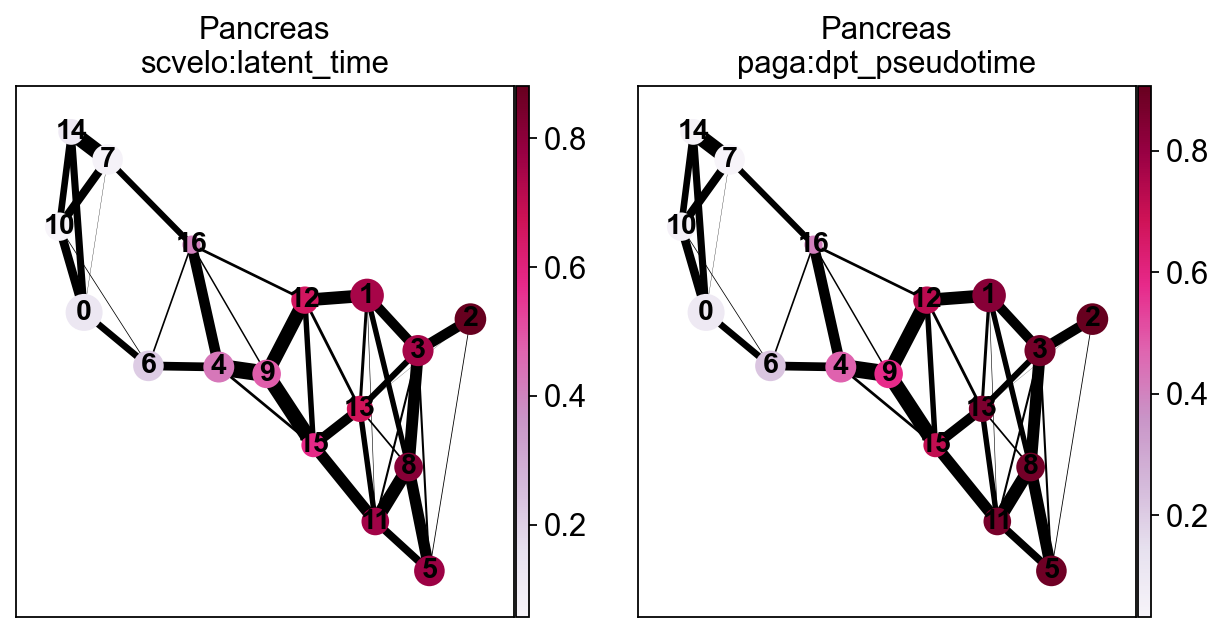

In [22]:
sc.pl.paga(scpancera.adata_test, color=['latent_time','dpt_pseudotime'],cmap='PuRd',
          title=['Pancreas\nscvelo:latent_time','Pancreas\npaga:dpt_pseudotime'],)
          #save='_fig3_pancreas.png')

--> added 'pos', the PAGA positions (adata.uns['paga'])


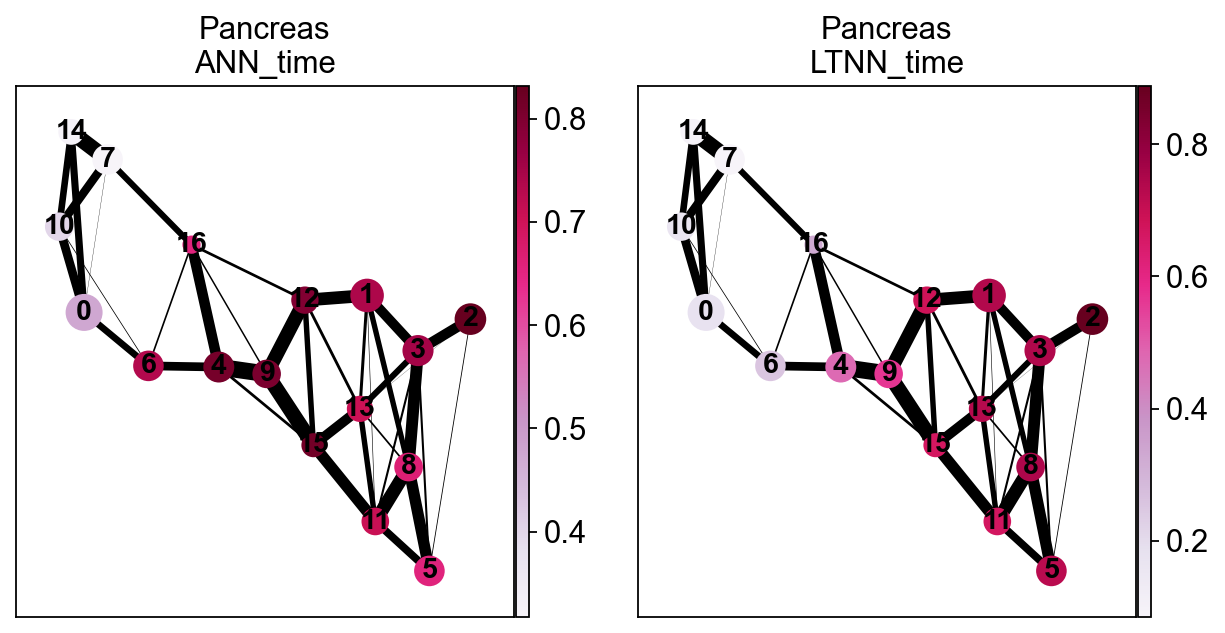

In [23]:
sc.pl.paga(scpancera.adata_test, color=['p_latent_time','LTNN_time'],cmap='PuRd',
          title=['Pancreas\nANN_time','Pancreas\nLTNN_time'],)
          #save='_fig3_pancreas.png')

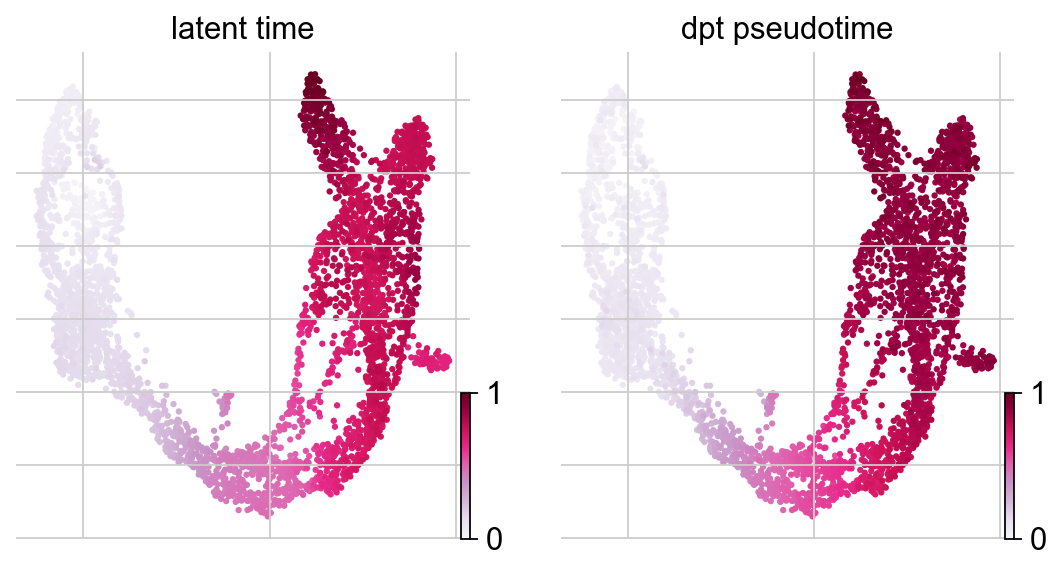

In [24]:
scv.pl.scatter(scpancera.adata_test, color=['latent_time','dpt_pseudotime'], 
               cmap='PuRd',legend_loc='right margin',)
               #save='_fig4_pancera_time.png')

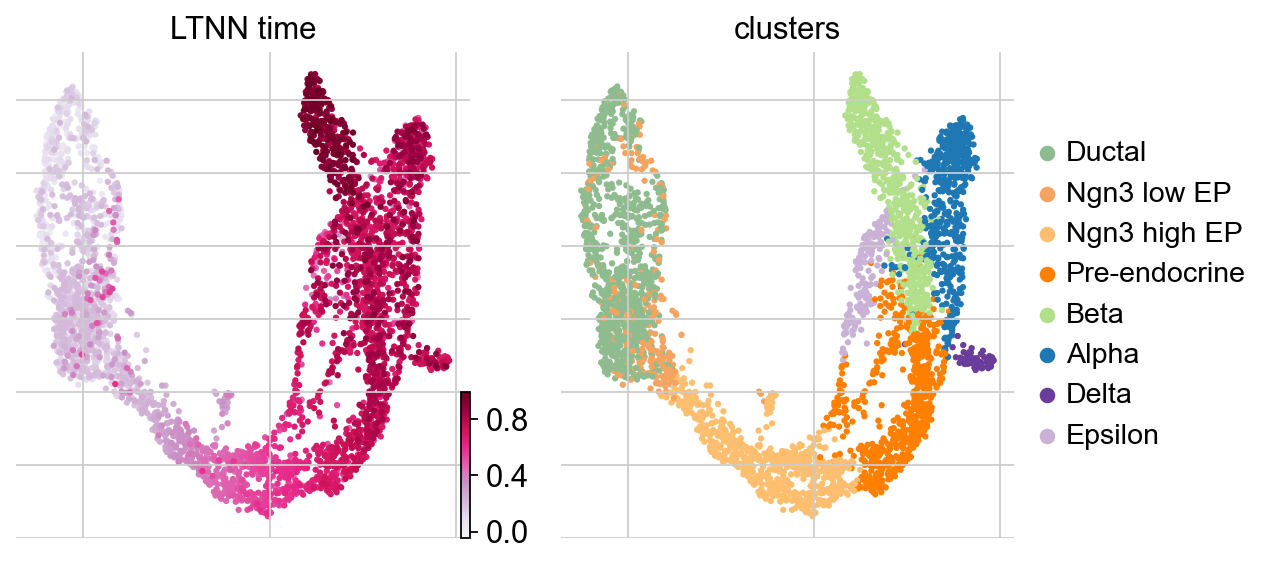

In [25]:
scv.pl.scatter(scpancera.adata_test, color=['LTNN_time','clusters'], 
               cmap='PuRd',legend_loc='right margin',)
               #save='_fig4_pancera_time.png')